<a href="https://colab.research.google.com/github/ChanceDurr/DS-Unit-4-Sprint-1-NLP/blob/master/module2-vector-representations/Chance_Dare_LS_DS_422_BOW_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [0]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import requests
from bs4 import BeautifulSoup

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [0]:
def get_job_links():
  links = []
  for i in range(0, 50, 10):
    if i == 0:
      response = requests.get('https://www.indeed.com/jobs?q=Data+Scientist&l=Seattle%2C+WA')
      soup = BeautifulSoup(response.text, 'html.parser')
      
      for posting in soup.find_all('a', attrs={'class':'jobtitle turnstileLink ', 'data-tn-element': 'jobTitle'}):
        links.append(posting.get('href'))
    else:
      response = requests.get(f'https://www.indeed.com/jobs?q=Data+Scientist&l=Seattle%2C+WA&start={i}')
      soup = BeautifulSoup(response.text, 'html.parser')
      
      for posting in soup.find_all('a', attrs={'class':'jobtitle turnstileLink ', 'data-tn-element': 'jobTitle'}):
        links.append(posting.get('href'))
        
    return links

In [0]:
def create_job_df():
  job_titles = []
  company_names = []
  description = []
  
  job_links = get_job_links()
  for link in job_links:
    response = requests.get('https://www.indeed.com/' + link)
    soup = BeautifulSoup(response.text, 'html.parser')
    job_titles.append(soup.find('h3').contents)
    description.append(soup.find('div', attrs={'id': 'jobDescriptionText'}).getText())
    company_names.append(soup.find('div', attrs={'class': 'icl-u-lg-mr--sm icl-u-xs-mr--xs'}).getText())
    
  df = pd.DataFrame({'job_title': job_titles, 'company': company_names, 'description': description})
  return df

In [0]:
df = create_job_df()

In [99]:
df.head()

,job_title,company,description
0,[Data Scientist / Data Analytics],Tredence Inc.,"Hi,Hope you are doing well.**This is Nasim Sha..."
1,[Data Scientist],Indeed Prime,Indeed Prime is a free service that connects q...
2,[Machine Repair Mechanic],BOEING,Machine Repair Mechanics do the following:Repa...
3,[Radiology Tech PRN Per Diem],Medely,Medely is an on-demand app that directly conne...
4,[Data Scientist],Lake Washington School District,Position Type:\n Professional & Technical Staf...


## 2) Use Spacy to tokenize / clean the listings 

In [0]:
nlp = spacy.load('en_core_web_lg')

In [0]:
desc_tokens = []
noun_chunks = []
for desc in df['description']:
  doc = nlp(desc)
  desc_tokens.append([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])
  noun_chunks.append(list(doc.noun_chunks))
  
df['tokens'] = desc_tokens
df['noun_chunks'] = noun_chunks

In [117]:
df.head()

,job_title,company,description,tokens,noun_chunks
0,[Data Scientist / Data Analytics],Tredence Inc.,"Hi,Hope you are doing well.**This is Nasim Sha...","[hi, hope, well.**This, Nasim, Shah, Tredence,...","[(you), (well.**This), (Nasim, Shah), (Tredenc..."
1,[Data Scientist],Indeed Prime,Indeed Prime is a free service that connects q...,"[Prime, free, service, connect, qualified, job...","[(Prime), (a, free, service), (qualified, job,..."
2,[Machine Repair Mechanic],BOEING,Machine Repair Mechanics do the following:Repa...,"[Machine, Repair, mechanic, following, repair,...","[(Machine, Repair, Mechanics), (the, following..."
3,[Radiology Tech PRN Per Diem],Medely,Medely is an on-demand app that directly conne...,"[Medely, demand, app, directly, connect, Radio...","[(Medely), (demand), (Radiology, Techs), (heal..."
4,[Data Scientist],Lake Washington School District,Position Type:\n Professional & Technical Staf...,"[position, type, \n , Professional, Technical,...","[(Position, Type), (Professional, &, Technical..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [0]:
vect = CountVectorizer(stop_words='english', min_df=.2, max_df=.8)
vect.fit(df['description'])
sparse_dtm = vect.transform(df['description'])

In [134]:
print(vect.get_feature_names())

['ability', 'able', 'actionable', 'additional', 'advanced', 'age', 'analysis', 'analytical', 'analytics', 'applicants', 'appropriate', 'available', 'based', 'best', 'better', 'big', 'build', 'building', 'business', 'candidate', 'class', 'color', 'comfortable', 'commitment', 'committed', 'common', 'communicate', 'communication', 'companies', 'company', 'complete', 'complex', 'computer', 'concisely', 'control', 'create', 'cross', 'culture', 'customer', 'day', 'decision', 'decisions', 'deep', 'degree', 'deliver', 'delivering', 'demand', 'design', 'develop', 'development', 'different', 'disability', 'diverse', 'drive', 'economics', 'efforts', 'employees', 'employer', 'employment', 'end', 'engineering', 'engineers', 'ensure', 'environment', 'equal', 'excellent', 'expect', 'expertise', 'expression', 'fast', 'field', 'focus', 'following', 'functional', 'future', 'gender', 'global', 'good', 'group', 'growing', 'growth', 'help', 'identity', 'impact', 'important', 'improve', 'includes', 'includi

In [138]:
sparse_dtm

<16x239 sparse matrix of type '<class 'numpy.int64'>'
	with 1352 stored elements in Compressed Sparse Row format>

In [140]:
sparse_dtm.todense()

matrix([[2, 0, 1, ..., 0, 1, 2],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 1],
        ...,
        [4, 0, 1, ..., 1, 0, 0],
        [4, 1, 0, ..., 0, 0, 1],
        [2, 0, 1, ..., 0, 1, 1]])

In [0]:
dtm = pd.DataFrame(sparse_dtm.todense(), columns=vect.get_feature_names())

In [142]:
dtm.head()

,ability,able,actionable,additional,advanced,age,analysis,analytical,analytics,applicants,appropriate,available,based,best,better,big,build,building,business,candidate,class,color,comfortable,commitment,committed,common,communicate,communication,companies,company,complete,complex,computer,concisely,control,create,cross,culture,customer,day,...,software,solutions,solving,sources,specifically,sql,stakeholders,statistical,statistics,status,strong,successful,support,systems,tableau,teams,technical,technologies,technology,test,testing,time,tools,training,type,understand,understanding,use,user,using,value,variety,visualization,way,wide,working,world,written,year,years
0,2,0,1,1,4,0,1,1,7,0,0,0,0,0,0,2,2,0,9,0,0,0,0,0,0,0,0,1,0,2,0,3,0,0,1,1,0,0,1,0,...,0,4,0,0,0,4,0,0,2,0,2,0,0,0,0,0,0,0,2,1,0,1,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,1,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,1,1,1,2,1,0,1,0,1,1,0,0,0,0,0,0,2,0,2,2,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,1,1,1,3,0,0,0,0,1,0,1,0,1,0,0,1,3,4,0,1,1
3,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,2,0,2,1,0,0,2,0,0,0,0,1,0,1,0,0,0,2,1


## 4) Visualize the most common word counts

In [0]:
from collections import Counter

def count(docs):
  word_counts = Counter()
  appears_in = Counter()
  
  total_docs = len(docs)
  
  for doc in docs:
    word_counts.update(doc)
    appears_in.update(set(doc))
    
  temp = zip(word_counts.keys(), word_counts.values())
  
  wc = pd.DataFrame(temp, columns = ['word', 'count'])
  
  wc['rank'] = wc['count'].rank(method='first', ascending=False)
  total = wc['count'].sum()
  
  wc['pct_total'] = wc['count'].apply(lambda x: x / total)
  
  wc = wc.sort_values(by='rank')
  wc['cul_pct+total'] = wc['pct_total'].cumsum()
  
  t2 = zip(appears_in.keys(), appears_in.values())
  ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
  wc = ac.merge(wc, on='word')
  
  wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
  
  return wc.sort_values(by='rank')

In [0]:
wc = count(df['tokens'])

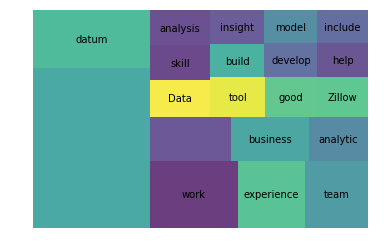

In [149]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [144]:
tfidf = TfidfVectorizer(stop_words = 'english', min_df=.2, max_df=.8)

sparse = tfidf.fit_transform(df['description'])

dtm = pd.DataFrame(sparse.todense(), columns = tfidf.get_feature_names())

dtm.head()

,ability,able,actionable,additional,advanced,age,analysis,analytical,analytics,applicants,appropriate,available,based,best,better,big,build,building,business,candidate,class,color,comfortable,commitment,committed,common,communicate,communication,companies,company,complete,complex,computer,concisely,control,create,cross,culture,customer,day,...,software,solutions,solving,sources,specifically,sql,stakeholders,statistical,statistics,status,strong,successful,support,systems,tableau,teams,technical,technologies,technology,test,testing,time,tools,training,type,understand,understanding,use,user,using,value,variety,visualization,way,wide,working,world,written,year,years
0,0.102004,0.0,0.068023,0.074098,0.21805,0.000000,0.044927,0.054512,0.357013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136046,0.095652,0.000000,0.430434,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.051002,0.000000,0.116874,0.000000,0.163537,0.0,0.000000,0.062887,0.068023,0.0,0.0,0.074098,0.000000,...,0.0,0.251546,0.0,0.0,0.0,0.21805,0.0,0.0,0.109025,0.000000,0.109025,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.148196,0.074098,0.000000,0.054512,0.000000,0.068023,0.068023,0.068023,0.062887,0.000000,0.0,0.042260,0.074098,0.000000,0.062887,0.0,0.000000,0.000000,0.000000,0.0,0.068023,0.089853
1,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111238,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.090215,0.601617,0.000000,0.096425,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.096425,0.0,0.0,0.000000,0.0,0.0,0.000000,0.131069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.054511,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.072704,0.072704,0.062458,0.062458,0.134428,0.072704,0.000000,0.051117,0.000000,0.051117,0.067214,0.0,0.000000,0.0,0.000000,0.0,0.0,0.158394,0.000000,0.145407,0.124917,0.058264,0.000000,0.0,0.079197,0.067214,0.000000,0.0,0.0,0.079197,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.145407,0.0,0.0,0.102234,0.000000,0.000000,0.079197,0.072704,0.058264,0.174791,0.000000,0.000000,0.000000,0.000000,0.067214,0.0,0.045168,0.000000,0.058264,0.000000,0.0,0.072704,0.135503,0.249833,0.0,0.072704,0.048018
3,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.342263,0.000000,0.245548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.144662,0.0,0.0,0.000000,0.000000,0.000000,0.114088,0.106425,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.319276,0.000000,0.132802,0.000000,0.000000,0.000000,0.122774,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.082504,0.000000,0.0,0.132802,0.000000
4,0.000000,0.0,0.000000,0.000000,0.00000,0.080673,0.053282,0.000000,0.060486,0.080673,0.000000,0.069304,0.069304,0.000000,0.000000,0.000000,0.000000,0.080673,0.000000,0.074581,0.0,0.080673,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.064650,0.000000,0.0,0.000000,0.074581,0.000000,0.0,0.0,0.000000,0.087878,...,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.161346,0.000000,0.0,0.0,0.000000,0.0,0.0,0.056720,0.000000,0.000000,0.000000,0.000000,0.129300,0.000000,0.161346,0.080673,0.000000,0.000000,0.149162,0.0,0.000000,0.000000,0.000000,0.074581,0.0,0.080673,0.000000,0.000000,0.0,0.161346,0.053282


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [151]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [152]:
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 0.96434628, 1.02116502, 1.04134164, 1.08480373]]),
 array([[ 0, 15, 13,  7,  5]]))

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 